# Predicting cloud cover using neural networks

In [17]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

from model_comparison import model_comparison
from resample import resample
import algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as n
from sklearn.linear_model import LinearRegression
#from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import train_test_split
%matplotlib inline
#%matplotlib notebook

from deepNN import NeuralNetRegressor

from sklearn.neural_network import MLPRegressor
from utils import mean_squared_error, A_R2, NRMSE

In [18]:
# reading test
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

In [19]:
#print(cloud.variables)
tcc = cloud.variables["tcc"][:][:][:].data

# Retriving ground values, these are available at six different pressure levels. 
rel = relative.variables["r"][:][:][:][:].data
#level = relative.variables["level"][:][0].data
spe = specific.variables["q"][:][:][:][:].data

surf_pre = pressure.variables["sp"][:][:][:].data
temp = temperature.variables["t2m"][:][:][:].data

In [20]:
def logit_inv(x): # sigmoid?
    return np.exp(x)/(1+np.exp(x))

def logit(x):
    return np.log((x + 1e-12)/(1+1e-12 - x))

In [21]:
# for one certain timestep 

n_days = 7

TCC = []
REL = []
SPE = []
PRE = []
TEMP = []


for t in range(int(n_days*4)):
    TCC.append(tcc[t][:][:].flatten())
    REL.append(rel[t][0][:][:].flatten())
    SPE.append(spe[t][0][:][:].flatten())
    PRE.append(surf_pre[t][:][:].flatten())
    TEMP.append(temp[t][:][:].flatten())


In [22]:
y =(np.array(TCC).flatten())
temp = y[y<1]
y[y>1] = temp.max()

X = np.array([np.array(REL).flatten(), np.array(SPE).flatten(), np.array(PRE).flatten(), np.array(TEMP).flatten()])
y = logit(np.array(TCC).flatten())

In [23]:
np.array(TCC).min(), np.array(TCC).max()

(9.99866855977416e-13, 1.0000000000009999)

In [24]:
y.min(), y.max()

(-26.93794050959591, 36.04365338911916)

In [25]:
np.shape(X[0]),np.shape(X[1]),np.shape(X[2]),np.shape(X[3]), np.shape(y)

((131516,), (131516,), (131516,), (131516,), (131516,))

In [26]:
y = y.reshape((len(y),1))
X = X.T

In [27]:
np.shape(X), np.shape(y)

((131516, 4), (131516, 1))

In [28]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, split_size = 0.2)
import sklearn.model_selection as s
X_train, X_test, y_train, y_test = s.train_test_split(X, y, test_size = 0.2)

"""from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fit = scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)"""

'from sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\nfit = scaler.fit(X_train)\n\nX_train = scaler.transform(X_train)\nX_test = scaler.transform(X_test)'

In [29]:
np.shape(X_train), np.shape(X_test), np.shape(y_train),  np.shape(y_test)

((105212, 4), (26304, 4), (105212, 1), (26304, 1))

In [30]:
y_train.max(), y_train.min()

(36.04365338911916, -26.93794050959591)

In [33]:
n_nodes = [10,30,50,100, 500]
eta = [0.0001, 0.001, 0.01, 0.1, 1.0]
lmd = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
epochs = [10,50,100]
batch_s = [1,10,50]


#for e in epochs:
#    for b in batch_s:
#        for et in eta:
#            for n in n_nodes:
model = NeuralNetRegressor(n_hidden = [30, 20],  
                           epochs=100, 
                           eta=0.001, 
                           shuffle=True, 
                           batch_size=1,
                           seed=None, 
                           alpha=0.0001, # dette er for relu ikke det samme som penaltien i scikit learn  
                           activation='sigmoid')

p = model.fit(X_train, y_train, X_test, y_test)
l = model.predict(X_test)
#print(" ")
#print( " for epochs :" + str(e) + " for bactsize : " + str(b) + " learningrat e : " + str(et) + "noden in middle layer n: " + str(n) + " traininperformance ois " + str(p.eval_['train_preform']) + "validation performance is "+ str(p.eval_['valid_preform']))
#print(" ")

                

In [ ]:
#p.eval_['train_preform']

In [ ]:
#p.eval_['valid_preform']

In [34]:
tr = p.eval_['cost_train']
te = p.eval_['cost_test']

x = np.arange(100)

In [35]:
temp = []
temp2 = []
for i in range(len(x)):
    temp.append(tr[i][0][0])
    temp2.append(te[i][0][0])

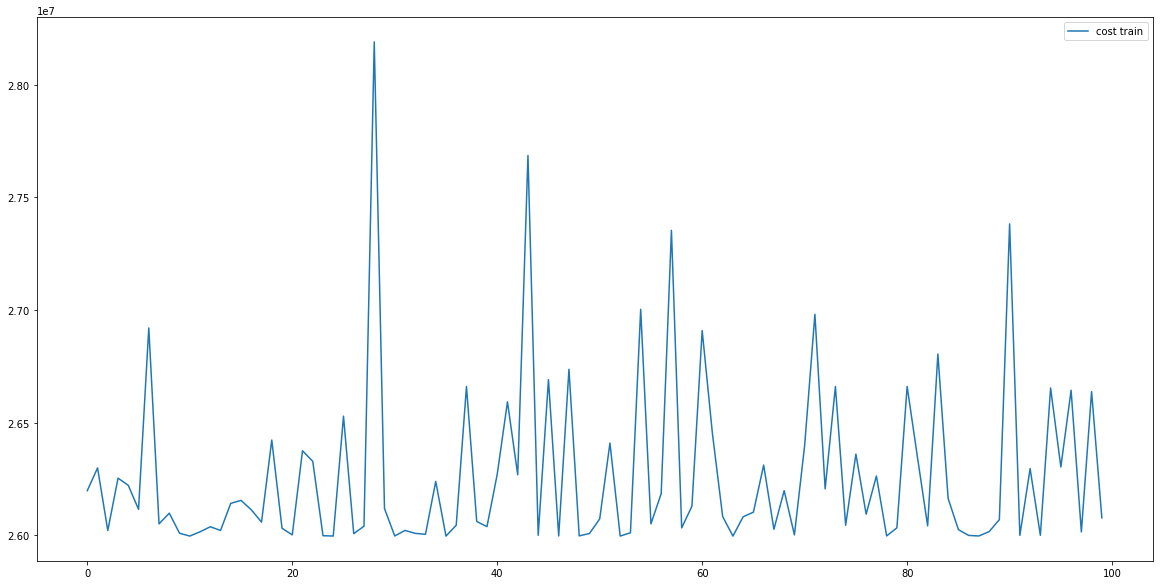

In [36]:
plt.figure(figsize = (20,10))
plt.plot(x,temp, label = "cost train")
#plt.plot(x,temp2, label = "cost test")
plt.legend()
plt.savefig("results/figures/cost_nn.png")

In [14]:
y_train = y_train.ravel()

In [15]:
y_train

array([ 2.94593381,  0.8415567 ,  0.45661411, ...,  1.19026945,
       -0.72485788,  1.12914103])

# Scikit MLP Regressor using one hidden layer

In [16]:
#n_nodes = [10,30,50,100, 500]
eta = [0.0001, 0.001, 0.01, 0.1, 1.0]
lmd = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
#epochs = [10,50,100] Scikit stopper på rett antall epochs
batch_s = [1,10,50]

n, p = X_train.shape

#for e in epochs:

for b in batch_s:
    for et in eta:
        for l in lmd:
            mlp = MLPRegressor(hidden_layer_sizes=(30,), 
                               activation = 'relu', # identity’, ‘logistic’, ‘tanh’, ‘relu’
                               solver = "adam", 
                               alpha = l, # penalty
                               batch_size = b, 
                               learning_rate_init = et)

            mlp.fit(X_train, y_train)
            y_pred = mlp.predict(X_test)
            #logistic activation uses the sigmoid function 
            mse = NRMSE(y_pred, y_test)
            ajusted_r2 = A_R2(y_pred, y_test, n, p)
            print(" eta : " + str(et) + " lmd "+ str(l) +"    batch size : " +  str(b)   + "   mse is " + str(mse) + " a r2  " + str(ajusted_r2))

 eta : 0.0001 lmd 0.0001    batch size : 1   mse is 1.0152668287369793 a r2  -358667.42984775547
 eta : 0.0001 lmd 0.001    batch size : 1   mse is 1.0537711968164556 a r2  -310826.83133555035
 eta : 0.0001 lmd 0.01    batch size : 1   mse is 4.423568025591926 a r2  -170874.72286245268
 eta : 0.0001 lmd 0.1    batch size : 1   mse is 0.9978992677088465 a r2  -399994.8472569592
 eta : 0.0001 lmd 1.0    batch size : 1   mse is 1.5080154420779808 a r2  -185758.3588135766
 eta : 0.0001 lmd 10    batch size : 1   mse is 1.3022721142126725 a r2  -209466.49252274146
 eta : 0.001 lmd 0.0001    batch size : 1   mse is 2.4478454879788356 a r2  -inf
 eta : 0.001 lmd 0.001    batch size : 1   mse is 2.4150933821227296 a r2  -8.991508903297183e+35
 eta : 0.001 lmd 0.01    batch size : 1   mse is 2.4779753124696664 a r2  -8.090701361405643e+36
 eta : 0.001 lmd 0.1    batch size : 1   mse is 2.487700620885454 a r2  -8.090608312035414e+36
 eta : 0.001 lmd 1.0    batch size : 1   mse is 2.4834835354623

 eta : 1.0 lmd 1.0    batch size : 50   mse is 2.339119658873412 a r2  -inf
 eta : 1.0 lmd 10    batch size : 50   mse is 2.1066950490401455 a r2  -9.042722459882836e+35


# Adding regularization may result in a better preformance despite of the network architecture ..? Doen't apper to be so, but check it out.